# Plants Clustering Analysis

A look at plants in different parts of North America.

## Data Source

- [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Plants)
- USDA, NRCS. 2008. The PLANTS Database ([Web Link](http://plants.usda.gov/), 31 December 2008). National Plant Data Center, Baton Rouge, LA 70874-4490 USA.

In [1]:
import csv

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.manifold import TSNE

In [6]:
# URL to access plant data
plants_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/plants/plants.data"

# Import the plant names only (first col in csv) into a DataFrame
plants = pd.read_csv(plants_data_url,
                     encoding='latin1',
                     header=None,
                     usecols=[0])

plants.columns = ["latin_name"]

plants.head()

,latin_name
0,abelia
1,abelia x grandiflora
2,abelmoschus
3,abelmoschus esculentus
4,abelmoschus moschatus


In [10]:
plants.shape

(34781, 1)

In [11]:
# Extract abbreviations to use as column names
cols = []

with open('./Data/abbrv.txt', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        cols.append(row[0])

print(cols)

['ab', 'ak', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'dc', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'pr', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'vi', 'wa', 'wv', 'wi', 'wy', 'al', 'bc', 'mb', 'nb', 'lb', 'nf', 'nt', 'ns', 'nu', 'on', 'pe', 'qc', 'sk', 'yt', 'dengl', 'fraspm']


In [12]:
# Add empty columns for each State/Province to plants df
for col in cols:
    plants[col] = np.nan

plants = plants.set_index('latin_name')
plants.head()

,ab,ak,ar,az,ca,co,ct,de,dc,fl,...,nt,ns,nu,on,pe,qc,sk,yt,dengl,fraspm
latin_name,,,,,,,,,,,,,,,,,,,,,
abelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abelia x grandiflora,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abelmoschus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abelmoschus esculentus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abelmoschus moschatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Extract State/Province for each plant
with open('./Data/plants.data', 'r', encoding='latin1') as f:
    reader = csv.reader(f)
    for row in reader:
        for state in row[1:]:
            plants.loc[row[0], state] = 1

In [15]:
plants.head()

,ab,ak,ar,az,ca,co,ct,de,dc,fl,...,ns,nu,on,pe,qc,sk,yt,dengl,fraspm,gl
latin_name,,,,,,,,,,,,,,,,,,,,,
abelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abelia x grandiflora,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abelmoschus,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abelmoschus esculentus,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abelmoschus moschatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Drop non-North American columns (dengl, fraspm, gl)
plants.drop(['dengl', 'fraspm', 'gl'], axis=1, inplace=True)

# Drop rows with all missing values (plants not in NA)
plants.dropna(how='all', inplace=True)

plants.shape

(34724, 67)

In [55]:
# Fill NaNs with zeroes
plants = plants.fillna(0)
plants.head()

,ab,ak,ar,az,ca,co,ct,de,dc,fl,...,lb,nf,nt,ns,nu,on,pe,qc,sk,yt
latin_name,,,,,,,,,,,,,,,,,,,,,
abelia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abelia x grandiflora,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abelmoschus,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abelmoschus esculentus,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abelmoschus moschatus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Split data into training and test sets
X_train, X_test = train_test_split(plants,
                                   test_size=0.3,
                                   random_state=42)

print(X_train.shape, X_test.shape)

(24306, 67) (10418, 67)


In [58]:
# Baseline clustering analysis
kmeans = KMeans(n_clusters=7, random_state=42)

kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [59]:
print(kmeans.inertia_)

85680.44156863347


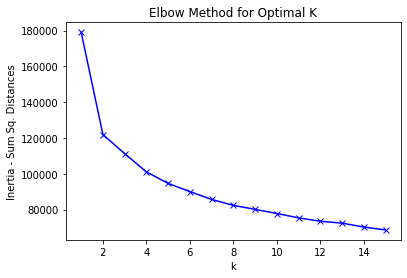

In [61]:
# Graph number of clusters vs. inertia for "elbow method"
sum_sq_dist = []

for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    sum_sq_dist.append(kmeans.inertia_)
    
plt.plot(range(1, 16),
         sum_sq_dist,
         'bx-')
plt.xlabel('k')
plt.ylabel('Inertia - Sum Sq. Distances')
plt.title('Elbow Method for Optimal K')
plt.show()

In [63]:
sum_sq_dist

[179033.12461943555,
 121903.67001528291,
 111270.20109817178,
 101080.29124931902,
 94621.03968599919,
 90082.84963627908,
 85680.44156863347,
 82369.55180307162,
 80149.85691074235,
 77825.03777067682,
 75398.37958157746,
 73500.92759601722,
 72448.60573102879,
 70289.54403563745,
 68665.05108319756]

[0.5206021170769546, 0.46944774688158764, 0.3501494151525396, 0.3417105426640366, 0.33350867069438594, 0.13727482081733883]


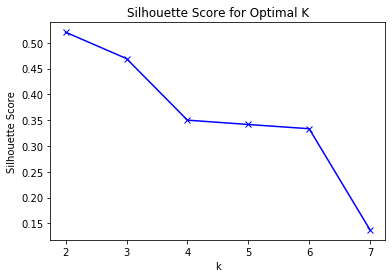

In [66]:
# Silhouette score method
sil_scores = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(X_train)
    score = silhouette_score(X_train, preds, metric='euclidean')
    sil_scores.append(score)

print(sil_scores)

plt.plot(range(2, 8),
         sil_scores,
         'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

The elbow method seems to support 2-4 overall clusters of plants, with the most dramatic change to inertia from 1 to 2 clusters. The silhouette scores also peaks at 2 clusters, and flattens at 4.

In [79]:
# Hierarchical clustering
hc = AgglomerativeClustering(affinity='euclidean', linkage='complete')
hc.fit(X_train)

print(hc.n_clusters_)

2


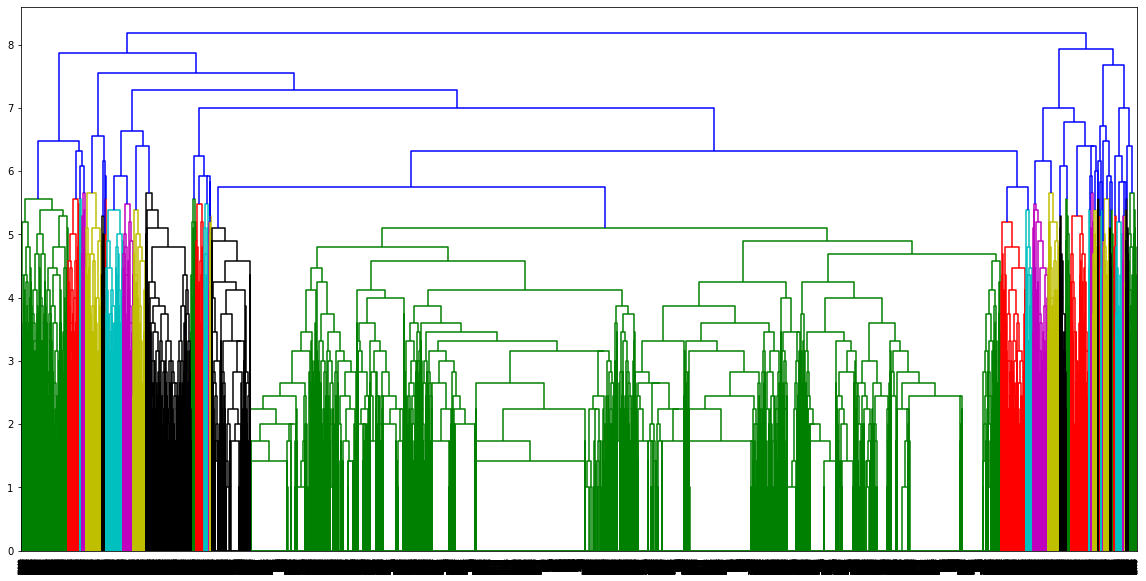

In [82]:
# Draw dendrogram - complete
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X_train, method='complete'))
plt.savefig('./Figures/Dendrogram-complete.jpg')
plt.show()

There seem to be 5 relatively distinct 'sub-clusters' in the green cluster, but it's harder to tell given the display of the red one.

In [74]:
# TSNE Visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=30)
tsne_results = tsne.fit_transform(X_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24306 samples in 0.788s...
[t-SNE] Computed neighbors for 24306 samples in 41.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24306
[t-SNE] Computed conditional probabilities for sample 2000 / 24306
[t-SNE] Computed conditional probabilities for sample 3000 / 24306
[t-SNE] Computed conditional probabilities for sample 4000 / 24306
[t-SNE] Computed conditional probabilities for sample 5000 / 24306
[t-SNE] Computed conditional probabilities for sample 6000 / 24306
[t-SNE] Computed conditional probabilities for sample 7000 / 24306
[t-SNE] Computed conditional probabilities for sample 8000 / 24306
[t-SNE] Computed conditional probabilities for sample 9000 / 24306
[t-SNE] Computed conditional probabilities for sample 10000 / 24306
[t-SNE] Computed conditional probabilities for sample 11000 / 24306
[t-SNE] Computed conditional probabilities for sample 12000 / 24306
[t-SNE] Computed conditional probabilities for sa

Text(0.5, 1.0, 'TSNE Results')

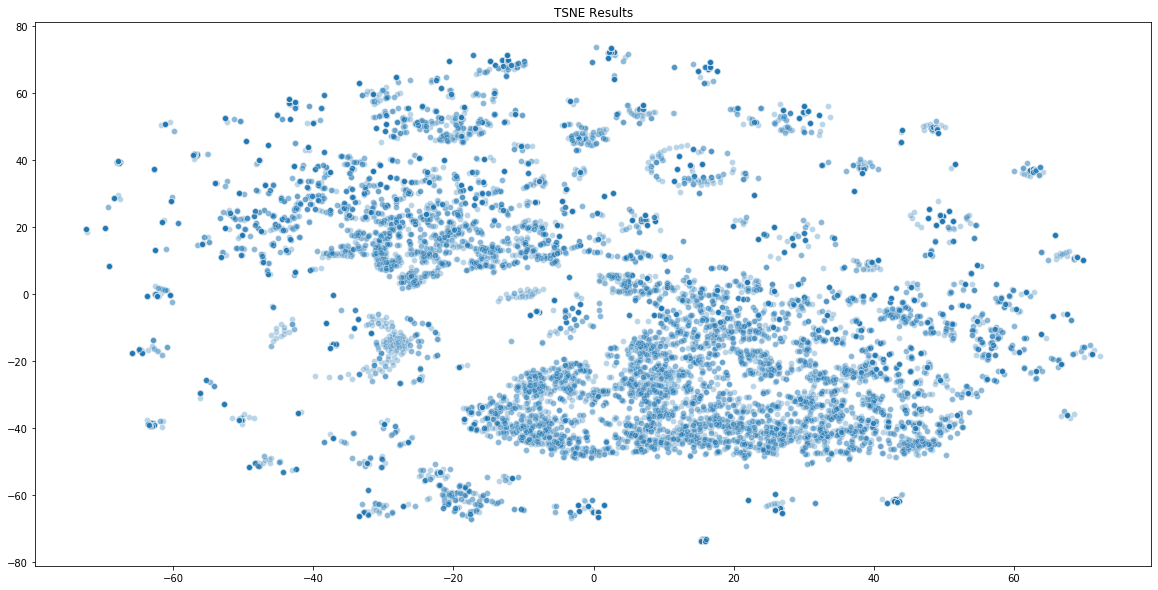

In [75]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=tsne_results[:, 0],
                y=tsne_results[:, 1],
                alpha=0.3)

plt.title('TSNE Results')